# real_shape_optimization

> Fix isogonal modes and get real space vertices by minimizing metric energy under (soft?) tension constraint.


In [ ]:
#| default exp isogonal

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from math import floor, ceil

import sys

from copy import deepcopy

from collections import Counter

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

from scipy.sparse import csc_matrix

## Definition of the cell shape tensor

Now based off of the sides

(-0.6, 1.6, -0.08660254037844387, 1.818653347947321)

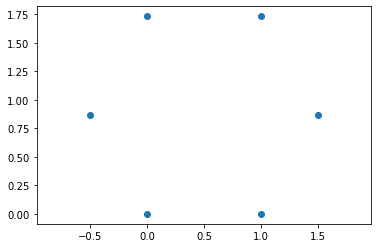

In [ ]:
polygon = np.array([[0, 0],
                    [1, 0],
                    [1+1/2, sqrt(3)/2],
                    [1, sqrt(3)],
                    [0, sqrt(3)],
                    [-1/2, sqrt(3)/2]
                   ])

polygon += np.random.normal(size=(6,2), scale=0)

plt.scatter(*polygon.T)
plt.axis("equal")

In [ ]:
#| export

def get_shape_tensor(poly: NDArray[Shape["N, 2"], Float], metric=False):
    """Shape tensor. normalized so that isotropic shape with unit edge length is identity"""
    edges = poly - anp.roll(poly, 1, axis=0)
    if metric: # don't normalize
        return 2 * anp.mean(anp.einsum("ei,ej->ije", edges, edges), axis=-1)
    lengths = anp.linalg.norm(edges, axis=-1)
    tensor = 2*anp.mean(anp.einsum("ei,ej->ije", edges, edges)/lengths, axis=-1)
    return tensor

In [ ]:
# note: only metric transforms cleanly under shear etc

get_shape_tensor(polygon, metric=False)

array([[1., 0.],
       [0., 1.]])

In [ ]:
# note also: the shape tensor == id does not guarantee that e.g. a hexgon is perfectly symemtric!
# is not injective

get_shape_tensor(polygon.dot(shear_mat(1.2)), metric=False)

array([[1.31143962, 0.        ],
       [0.        , 0.73993   ]])

## Code for mesh energy

In [ ]:
#| export

@patch
def set_centroid(self: HalfEdgeMesh):
    """Set dual positions to triangle centroid"""
    for fc in self.faces.values():
        vecs = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            vecs.append(he.vertices[0].coords)
            he = he.nxt
            returned = (he == start_he)
        fc.dual_coords = np.mean(vecs, axis=0)

In [ ]:
#| export

@patch
def transform_dual_vertices(self: HalfEdgeMesh, trafo: Union[Callable, NDArray[Shape["2, 2"], Float]]):
    for fc in self.faces.values():
        if isinstance(trafo, Callable):
            fc.dual_coords = trafo(fc.dual_coords)
        else:
            fc.dual_coords = trafo.dot(fc.dual_coords)

In [ ]:
#| export

@patch
def cellplot(self: HalfEdgeMesh, alpha=1):
    """Plot based on primal positions. Might be slow because loops over faces"""
    for fc in self.faces.values():
        for he in fc.hes:
            nghb = he.twin.face
            if nghb is not None:
                line = np.stack([fc.dual_coords, nghb.dual_coords])
                plt.plot(*line.T, c="k", alpha=alpha)

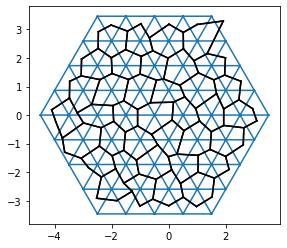

In [ ]:
# now write code to get primal energy function for mesh. first, without angle constraint.

mesh = get_tri_hemesh(noise=0, ny=9, nx=9)

#mesh.flip_edge(86)  # this creates an example of an edge with != 6 sides
mesh.set_centroid()
mesh.transform_dual_vertices(lambda x: x+np.random.normal(scale=.1))
mesh.set_rest_lengths() 

mesh.cellplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

# 19 complete primal faces

In [ ]:
#| export

@patch
def dual_vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    dual_vertex_vector = np.stack([self.faces[key].dual_coords for key in face_keys]).T
    return np.hstack([dual_vertex_vector[0], dual_vertex_vector[1]])
       
@patch
def initial_cond_to_dual_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    dual_vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(face_keys, dual_vertex_vector)}


In [ ]:
mesh.dual_vertices_to_initial_cond().shape, len(mesh.faces)

((192,), 96)

In [ ]:
len(mesh.vertices), len([v._vid for v in mesh.vertices.values()
                         if not any([he.face is None for he in v.incident])])

(61, 37)

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
x0.shape

(192,)

In [ ]:
#| export

def get_face_neighbors(vertex):
    """Get face neighbors of vertex"""
    neighbors = []
    start_he = vertex.incident[0]
    he = start_he
    returned = False
    while not returned:
        neighbors.append(he.face)
        he = he.nxt.twin
        returned = (he == start_he)
    return neighbors

@patch
def get_shape_tensors(self: HalfEdgeMesh):
    """Get current shape tensors as dict"""
    # iterate around vertex.
    result_dict = {}
    for v in self.vertices.values():
        neighbors = get_face_neighbors(v)
        if not (None in neighbors):
            polygon = np.stack([fc.dual_coords for fc in neighbors])
            result_dict[v._vid] = get_shape_tensor(polygon, metric=True)
        else: # leave at default value
            result_dict[v._vid] = np.eye(2)
    return result_dict

@patch
def set_rest_shapes(self: HalfEdgeMesh):
    """Set rest shapes to current shapes"""
    shape_dict = self.get_shape_tensors()
    for v in self.vertices.values():
        v.rest_shape = shape_dict[v._vid]

In [ ]:
mesh.get_shape_tensors() # looks reasonable

{0: array([[1., 0.],
        [0., 1.]]),
 1: array([[1., 0.],
        [0., 1.]]),
 2: array([[1., 0.],
        [0., 1.]]),
 3: array([[1., 0.],
        [0., 1.]]),
 4: array([[1., 0.],
        [0., 1.]]),
 5: array([[1., 0.],
        [0., 1.]]),
 6: array([[0.52437868, 0.02509829],
        [0.02509829, 0.64225133]]),
 7: array([[0.69777016, 0.13606719],
        [0.13606719, 0.57806488]]),
 8: array([[ 0.51498957, -0.00773833],
        [-0.00773833,  0.66510238]]),
 9: array([[0.63009086, 0.03455383],
        [0.03455383, 0.65738942]]),
 10: array([[1., 0.],
        [0., 1.]]),
 11: array([[1., 0.],
        [0., 1.]]),
 12: array([[ 0.60069735, -0.00541574],
        [-0.00541574,  0.53186214]]),
 13: array([[ 0.56073158, -0.01687389],
        [-0.01687389,  0.56296995]]),
 14: array([[0.63093006, 0.00731483],
        [0.00731483, 0.49432797]]),
 15: array([[ 0.58731437, -0.01013828],
        [-0.01013828,  0.64083294]]),
 16: array([[0.79578131, 0.10533886],
        [0.10533886, 0.52265

In [ ]:
@patch
def get_primal_energy_fct_noconstr(self: HalfEdgeMesh, mod_bulk=1, mod_shear=1e-3):
    """Get function to compute primal energy from primal vertices. No angle constraint, just temp function"""
    primal_face_list = []
    rest_shapes = []

    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None

    # iterate around vertex.
    for v in self.vertices.values():
        neighbors = get_face_neighbors(v)
        if not (None in neighbors):
            primal_face_list.append(anp.array([fc._fid for fc in neighbors]))
            rest_shapes.append(v.rest_shape)

    # cells might have differing #vertices, so don't make primal face list into array
    rest_shapes = anp.array(rest_shapes)
    n_faces = len(self.faces)

    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        tensors = []
        for fc in primal_face_list:
            pts = anp.stack([x[fc], y[fc]], axis=-1)
            tensors.append(get_shape_tensor(pts))
        tensors = anp.array(tensors)
        delta = tensors - rest_shapes
        E = anp.sum(mod_bulk*(delta[:,0,0]+delta[:,1,1])**2
                  + mod_shear*(delta[:,0,0]**2+2*delta[:,0,1]**2+delta[:,1,1]**2))        
        return E
    
    return get_E, agrad(get_E)

In [ ]:
get_E, jac = mesh.get_primal_energy_fct_noconstr()
get_E(x0)  # 5.14846355788931

24.49988552007384

In [ ]:
#| notest
%timeit _ = get_E(x0) # 3 ms for 

3.07 ms ± 55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#| notest
%timeit _ = jac(x0) # 21

21 ms ± 947 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Minimization, unconstrained

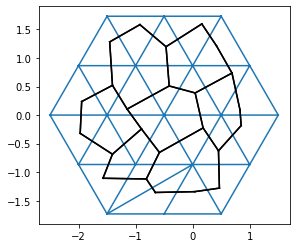

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.flip_edge(7)  # this creates an example of an edge with != 6 sides
mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.set_rest_shapes()  # required, to make the scale of the rest shapes correct.
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.11)) #shear_mat(1.2)@x)

mesh.cellplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
mesh.get_shape_tensors()[8], mesh.vertices[8].rest_shape

(array([[ 0.53963671, -0.03939688],
        [-0.03939688,  0.60476855]]),
 array([[0.57735027, 0.        ],
        [0.        , 0.57735027]]))

In [ ]:
%%time
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct_noconstr(mod_bulk=1, mod_shear=1)
get_E(x0)

CPU times: user 2.21 ms, sys: 998 µs, total: 3.2 ms
Wall time: 2.25 ms


0.23512689388909108

In [ ]:
%%time

sol = optimize.minimize(get_E, x0, method="BFGS", options={"gtol": 1e-5})
print(sol["message"])
get_E(sol["x"])

Optimization terminated successfully.
CPU times: user 675 ms, sys: 240 µs, total: 675 ms
Wall time: 675 ms


1.2275106808967743e-10

In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]

In [ ]:
mesh.get_shape_tensors()[8], mesh.vertices[8].rest_shape, mesh.vertices[8].coords

(array([[ 5.77351859e-01, -9.28253389e-07],
        [-9.28253389e-07,  5.77351092e-01]]),
 array([[0.57735027, 0.        ],
        [0.        , 0.57735027]]),
 array([-1.5,  0. ]))

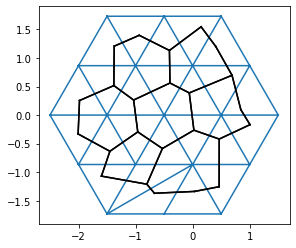

In [ ]:
# now write code to get primal energy function for mesh. first, without angle constraint.

mesh.cellplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

# 19 complete primal faces

## Angle constraint energy

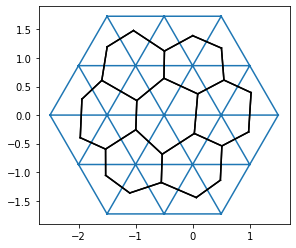

In [ ]:
# iterate over edges and ensure angle primal | dual = 0

mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.set_rest_shapes()  # required, to make the scale of the rest shapes correct.
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.05))

mesh.cellplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
#| export

@patch
def get_angle_deviation(self: HalfEdgeMesh):
    """Angle between primal and dual edges. For diagnostics"""
    angle_deviation = {}

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None):
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            primal_edge = he.face.dual_coords - he.twin.face.dual_coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = primal_edge / np.linalg.norm(primal_edge)        
            angle_deviation[he._heid] = np.dot(dual_edge, primal_edge)**2
    return angle_deviation

In [ ]:
sum(mesh.get_angle_deviation().values()) / 2

0.46068482638191866

In [ ]:
## now make this into arrays ... 

e_dual = [] # dual vertices do not move during optiomization, so collect the actual edges
e_lst_primal = [] # for primal, collect the indices

face_key_dict = {key: ix for ix, key in enumerate(sorted(mesh.faces.keys()))}

for he in mesh.hes.values():
    if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
        dual_edge = he.vertices[1].coords-he.vertices[0].coords
        dual_edge = dual_edge / np.linalg.norm(dual_edge)
        primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
        e_dual.append(dual_edge)
        e_lst_primal.append(primal_edge)

e_dual = anp.array(e_dual)
e_lst_primal = anp.array(e_lst_primal)
n_faces = len(mesh.faces)

In [ ]:
# now collect the primal coords

x0 = mesh.dual_vertices_to_initial_cond()

x, y = (x0[:n_faces], x0[n_faces:])
pts = anp.stack([x, y], axis=-1)
e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T

anp.sum(anp.einsum('ei,ei->e', e_primal, e_dual)**2)

0.4606848263819186

In [ ]:
#| export

@patch
def get_primal_energy_fct(self: HalfEdgeMesh, mod_bulk=1, mod_shear=1e-3, angle_penalty=1e2):
    """Get function to compute primal energy from primal vertices."""
    
    # stuff for the shape tensor energy
    primal_face_list = []
    rest_shapes = []
    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = get_face_neighbors(v)
        if not (None in neighbors):
            primal_face_list.append(anp.array([fc._fid for fc in neighbors]))
            rest_shapes.append(v.rest_shape)
    # cells might have differing #vertices, so don't make primal face list into array
    rest_shapes = anp.array(rest_shapes)
    n_faces = len(self.faces)

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optiomization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)    
    center = anp.mean([fc.dual_coords for fc in self.faces.values()], axis=0)

    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        # shape energy
        tensors = []
        for fc in primal_face_list:
            pts = anp.stack([x[fc], y[fc]], axis=-1)
            tensors.append(get_shape_tensor(pts, metric=True))
        tensors = anp.array(tensors)
        delta = tensors - rest_shapes
        E_shape = anp.mean(mod_bulk*(delta[:,0,0]+delta[:,1,1])**2
                         + mod_shear*(delta[:,0,0]**2+2*delta[:,0,1]**2+delta[:,1,1]**2))
        # angle penalty
        pts = anp.stack([x, y], axis=-1)
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return E_shape + E_angle + E_trans
    
    return get_E, agrad(get_E)

## Minimization, constrained

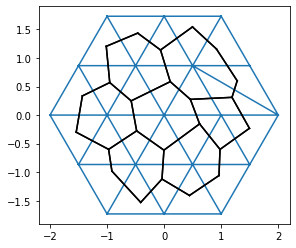

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
mesh.transform_vertices(lambda x: x-mean)


mesh.flip_edge(11)  # this creates an example of an edge with != 6 sides. e.g. 9
mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.set_rest_shapes()  # required, to make the scale of the rest shapes correct.
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.06)) #shear_mat(1.2)@x)
#mesh.transform_vertices(shear_mat(1.3)) # 1.31almost 90 degree angles

mesh.cellplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
max(mesh.get_angles().values()) / pi

0.6666666666666666

In [ ]:
%%time
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct(mod_bulk=1, mod_shear=.1, angle_penalty=10)
get_E(x0)

CPU times: user 5.34 ms, sys: 313 µs, total: 5.65 ms
Wall time: 4.2 ms


0.5439033863558951

In [ ]:
%%time

sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", options={"gtol": 1e-3})
print(sol["message"])
get_E(sol["x"])

# for the 5*5 example:
# .5s for BFGS
# 2s for CG
# 2.5 for BFGS without jac
# 2.6s for Newton-CG
# 1.8 for trust-ncg
# 2 for trust-krylov

# fine to set the gtol to 1e-3

Optimization terminated successfully.
CPU times: user 336 ms, sys: 578 µs, total: 337 ms
Wall time: 338 ms


0.0015625216984617822

In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]

In [ ]:
mesh.get_shape_tensors()[8], mesh.vertices[8].rest_shape, mesh.vertices[8].coords

(array([[ 0.34047, -0.00607],
        [-0.00607,  0.32485]]),
 array([[3.33333e-01, 9.25186e-18],
        [9.25186e-18, 3.33333e-01]]),
 array([-1.00000e+00, -1.63612e-16]))

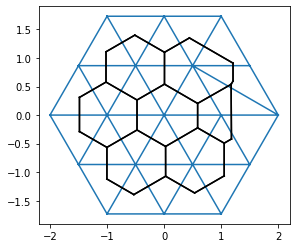

In [ ]:
# completely correct - but can have problem at boundary if there was an edge flip!
# in this case, ever self-intersection can occur.

mesh.cellplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

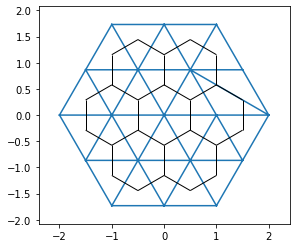

In [ ]:
mesh.voronoiplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

Now we still need to compute the primal edge lengths! indexed by `_heid`

In [ ]:
#| export

@patch
def get_primal_edge_lens(self: HalfEdgeMesh):
    return {he._heid: np.linalg.norm(he.face.dual_coords-he.twin.face.dual_coords)
            for key, he in self.hes.items() if (he.face is not None) and (he.twin.face is not None)}
    
    return None

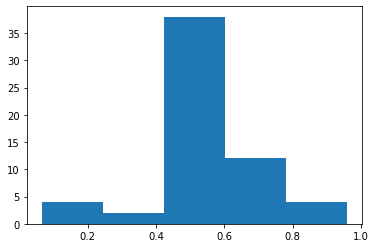

In [ ]:
plt.hist(mesh.get_primal_edge_lens().values(), bins=5);

In [ ]:
primal_lengths = mesh.get_primal_edge_lens()
argmin = min(primal_lengths, key=primal_lengths.get)
argmin, primal_lengths[argmin]

(11, 0.06649379775087715)

In [ ]:
# to do: check for errors by writing a function that checks polygon intersection:
# is any point in any other polygon?
# use half-space check to do this

## Full simulation, as example

In [ ]:
def temp_plot(msh):
    msh.cellplot()
    msh.triplot()
    #plt.title("initial")
    plt.xlim([-3, 3])
    plt.ylim([-2, 2])
    plt.gca().set_aspect("equal", adjustable="box");


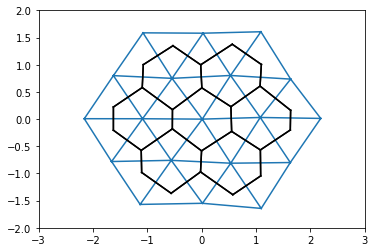

In [ ]:
mesh = get_tri_hemesh(noise=0, nx=5, ny=5)
mesh.set_voronoi(); mesh.set_rest_shapes()  # to make the scale of the rest shapes correct.
mesh.transform_vertices(lambda x: shear_mat(1.1)@x+np.random.normal(size=2, scale=.025))
# set origin
mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
mesh.transform_vertices(lambda x: x-mean)

mesh.set_rest_lengths() 
mesh.set_voronoi()

temp_plot(mesh)

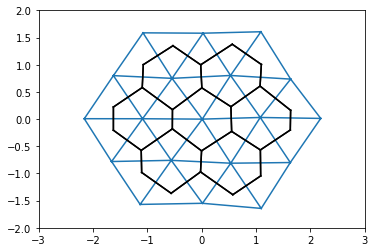

0
1
2
3
4
5
6
7
8
9
10


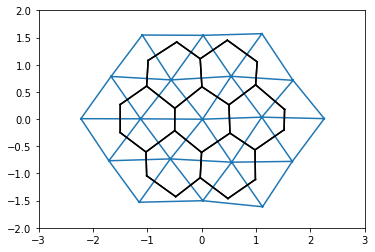

11
12
13
14
15
16
17
18
19
20


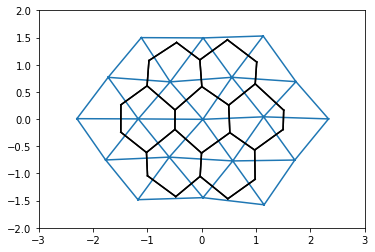

21
22
23
24
25
26
27
28
29
30


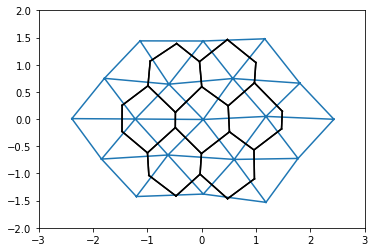

31
32
33
34
35
36
37
38
39
40


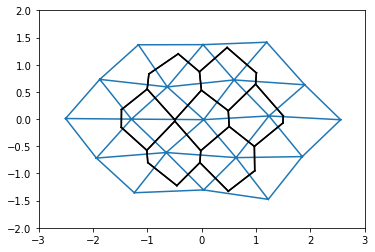

flip


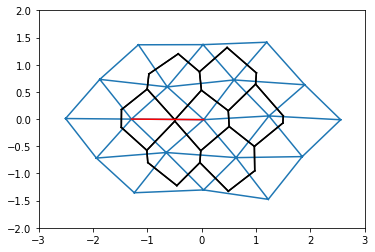

41
42
43
44
45
46
47
48
49
50


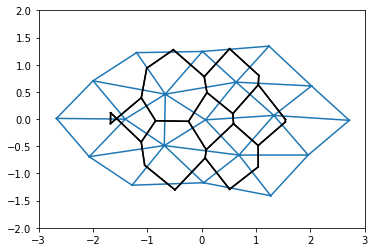

flip


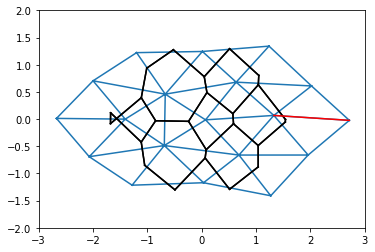

51
flip


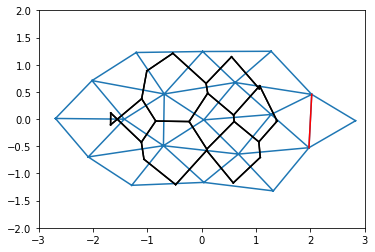

52
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


In [ ]:
#| notest
#%%time

## simulate

m = 2
k = .25
dt = .005

mod_shear = .1
mod_bulk = 1
angle_penalty = 10

epsilon_l = .05

meshes = [mesh]
times = [0]

temp_plot(mesh)
plt.show()
plt.close()

T1_count = [0]

for i in range(100):
    print(i)
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, k=k, m=m)
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    # flatten triangulation
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print("Triangulation optimization failed")
        print(sol["message"])
        meshes.append(deepcopy(mesh))
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
    # primal optimization
    get_E, grd = mesh.get_primal_energy_fct(mod_bulk=mod_bulk, mod_shear=mod_shear, angle_penalty=angle_penalty)
    x0 = mesh.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=grd, method="BFGS", tol=1e-3)
    if sol["status"] !=0:
        print("Cell shape optimization failed")
        print(sol["message"])
        meshes.append(deepcopy(mesh))
        break
    new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
    for key, val in mesh.faces.items():
        val.dual_coords = new_coord_dict[key]
    if i%10 == 0 and i>0:
        temp_plot(mesh)
        plt.show()
        plt.close()
    # compute primal lengths and carry out an edge flip if required
    primal_lengths = mesh.get_primal_edge_lens()
    argmin = min(primal_lengths, key=primal_lengths.get)
    if primal_lengths[argmin] < epsilon_l:        
        # resetting the active and passive tensions
        mesh.reset_rest_passive_flip(mesh.hes[argmin])
        try:
            print("flip")
            # highlight flipped edge
            temp_plot(mesh)
            line = np.stack([mesh.hes[argmin].vertices[0].coords, mesh.hes[argmin].vertices[1].coords])
            plt.plot(*line.T, c="r")
            plt.show()
            plt.close()
            mesh.flip_edge(argmin)
            T1_count.append(T1_count[-1]+1)
        except ValueError:
            continue
    else:
        T1_count.append(T1_count[-1])
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

In [ ]:
# to do: function for energy from the shape tensor
# plotting function to color cells, or triangles by dict

In [ ]:
#| export

def get_shape_energy(tensor, rest_shape=np.eye(2), mod_shear=0.1, mod_bulk=1):
    delta = tensor-rest_shape
    return mod_shear*np.trace(delta@delta)+mod_bulk*np.trace(delta)**2

@patch
def get_shape_energies(self: HalfEdgeMesh, mod_shear=0.1, mod_bulk=1):
    energy_dict = {}
    tensors = mesh.get_shape_tensors()
    rests = {v._vid: v.rest_shape for v in mesh.vertices.values()}
    for key, val in tensors.items():
        energy_dict[key] = get_shape_energy(val, rest_shape=rests[key],
                                            mod_shear=mod_shear, mod_bulk=mod_bulk)
    return energy_dict

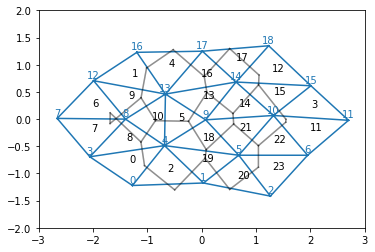

In [ ]:
t = 50


meshes[t].cellplot(alpha=.25)
meshes[t].triplot()
meshes[t].labelplot()


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


In [ ]:
meshes[t].get_shape_tensors()[10]

array([[ 0.31185, -0.01286],
       [-0.01286,  0.35461]])

In [ ]:
rest = meshes[t].vertices[10].rest_shape
rest

array([[3.33333e-01, 3.70074e-17],
       [3.70074e-17, 3.33333e-01]])

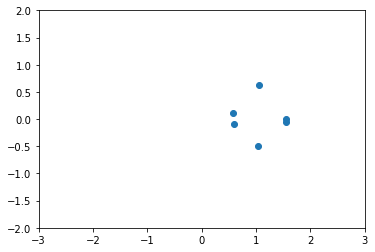

In [ ]:
pts = np.stack([fc.dual_coords for fc in get_face_neighbors(meshes[t].vertices[10])])
plt.scatter(*pts.T)

plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
get_shape_tensor(pts)
 # ??? error 

array([[ 0.45081, -0.00842],
       [-0.00842,  0.55941]])

In [ ]:
{key: np.round(100*val, decimals=2)
 for key, val in meshes[t].get_shape_energies().items()}

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.01,
 6: 0.0,
 7: 0.0,
 8: 0.01,
 9: 0.07,
 10: 1.49,
 11: 0.0,
 12: 0.0,
 13: 0.01,
 14: 0.01,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0}

In [ ]:
#| export

@patch
def labelplot(self: HalfEdgeMesh, vertex_labels=True, face_labels=True,
                     halfedge_labels=False):
    """for debugging purposes, a fct to plot a trimesh with labels attached"""
    if face_labels:
        for fc in self.faces.values():
            centroid = np.mean([he.vertices[0].coords for he in fc.hes], axis=0)
            plt.text(*centroid, str(fc._fid), color="k")
    if vertex_labels:
        for v in self.vertices.values():
            plt.text(*(v.coords+np.array([0,.05])), str(v._vid),
                     color="tab:blue", ha="center")
    if halfedge_labels:
        for he in self.hes.values():
            if he.duplicate:
                centroid = np.mean([v.coords for v in he.vertices], axis=0)
                plt.text(*centroid, str(he._heid), color="tab:orange")

In [ ]:
def temp_plot(msh):
    msh.cellplot(alpha=.25)
    msh.triplot()
    #plt.title("initial")
    plt.xlim([-3, 3])
    plt.ylim([-2, 2])
    plt.gca().set_aspect("equal", adjustable="box");


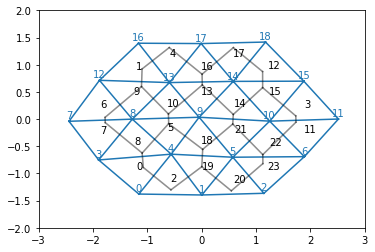

In [ ]:
#| export

# for debugging purposes, a fct to plot a trimesh with labels attached

meshes[34].cellplot(alpha=.25)
meshes[34].triplot()
meshes[34].labelplot()


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


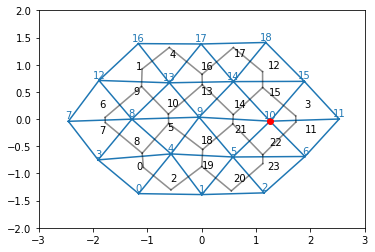

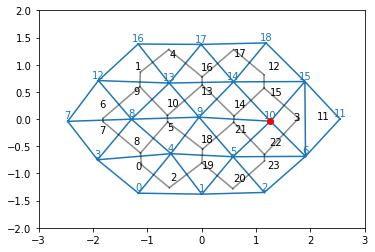

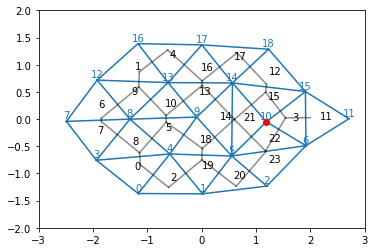

In [ ]:
temp_plot(meshes[35])
plt.scatter(*meshes[35].vertices[10].coords, color="r")
meshes[35].labelplot()
plt.show()

temp_plot(meshes[36])
plt.scatter(*meshes[36].vertices[10].coords, color="r")
meshes[36].labelplot()
plt.show()

temp_plot(meshes[37])
plt.scatter(*meshes[37].vertices[10].coords, color="r")
meshes[37].labelplot()
plt.show()

In [ ]:
# multiple problems, mainly at the edges, and then progagating inwards
# need to fix: simulation currently has open cells at the boundary
# where primal vertices only belong to once cell. might need to add "mirror"
# second, the shape tensor does not stronlgy repell away from self intersecting polygons

corners can develop:

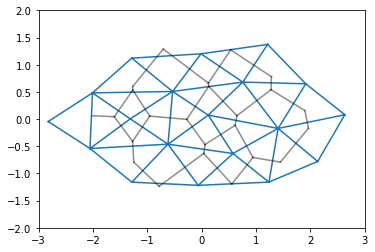

self intersections can develop:

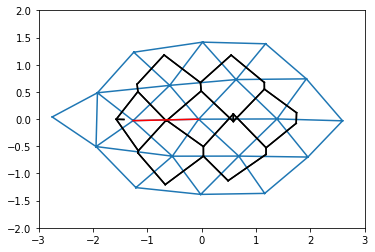

Very messed up example:

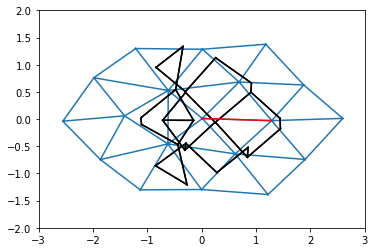

(-1.105, 1.205, -1.1, 1.1)

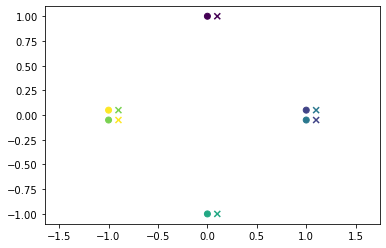

In [ ]:
poly_example = np.array([[0,  1.0],
                         [1,  0.05],
                         [1, -0.05],
                         [0, -1.0],
                         [-1,-0.05],
                         [-1, 0.05]])

poly_intersect = np.array([[0,  1.0],
                           [1, -0.05],
                           [1,  0.05],
                           [0, -1.0],
                           [-1, 0.05],
                           [-1,-0.05]])


plt.scatter(*poly_example.T, c =np.arange(6))
plt.scatter(*(poly_intersect+np.array([.1,0])).T, c =np.arange(6), marker='x')

plt.axis("equal")

In [ ]:
metric = True
delta_1 = 10*(get_shape_tensor(poly_example, metric=metric)-np.eye(2))
delta_2 = 10*(get_shape_tensor(poly_intersect, metric=metric)-np.eye(2))

In [ ]:
np.trace(delta_1)**2, np.trace(delta_2)**2

(29.521111111111075, 65.60999999999997)

In [ ]:
np.trace(delta_1@delta_1), np.trace(delta_2@delta_2)

(15.521111111111095, 33.83222222222221)

In [ ]:
# metric true seems better behaved


<function __main__.get_shape_tensor(poly: nptyping.base_meta_classes.NDArray, metric=False)>

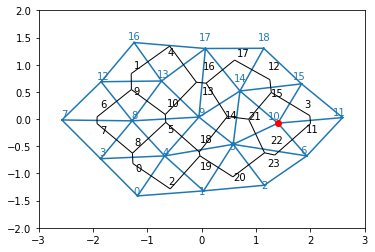

In [ ]:
#meshes[33].cellplot(alpha=.25)
meshes[33].voronoiplot(alpha=.25)
meshes[33].triplot()

meshes[32].labelplot()
plt.scatter(*meshes[33].vertices[10].coords, color="r")

plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


In [ ]:
[(fc._fid, np.round(fc.dual_coords, decimals=1))
 for  fc in get_face_neighbors(meshes[31].vertices[10])] # ok

[(11, array([ 1.7, -0.2])),
 (22, array([ 1.1, -0.7])),
 (21, array([ 0.6, -0. ])),
 (14, array([0.6, 0. ])),
 (15, array([1.1, 0.5])),
 (3, array([1.7, 0.1]))]

In [ ]:
[(fc._fid, np.round(fc.dual_coords, decimals=1))
 for  fc in get_face_neighbors(meshes[32].vertices[10])]

[(15, array([1.1, 0.5])),
 (3, array([1.7, 0.1])),
 (11, array([ 1.7, -0.2])),
 (22, array([ 1.1, -0.7])),
 (21, array([ 0.6, -0. ]))]

In [ ]:
[(fc._fid, np.round(fc.dual_coords, decimals=1))
 for  fc in get_face_neighbors(meshes[33].vertices[10])]

[(15, array([1.2, 0.3])),
 (3, array([ 1.9, -0.2])),
 (11, array([ 1.9, -0. ])),
 (22, array([ 1.2, -0.6])),
 (21, array([ 1., -0.]))]

In [ ]:
meshes[31].get_shape_tensors()[10]

array([[0.56477322, 0.00082882],
       [0.00082882, 0.58844851]])

In [ ]:
meshes[32].get_shape_tensors()[10]

array([[0.66918332, 0.00830407],
       [0.00830407, 0.71166739]])

In [ ]:
meshes[33].get_shape_tensors()[10]

array([[0.55465346, 0.00560227],
       [0.00560227, 0.59966767]])

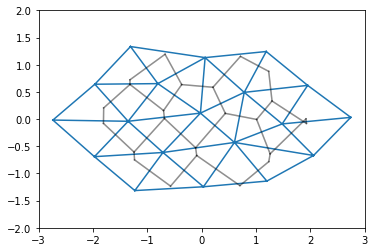

In [ ]:
temp_plot(meshes[-1])

<matplotlib.collections.PathCollection>

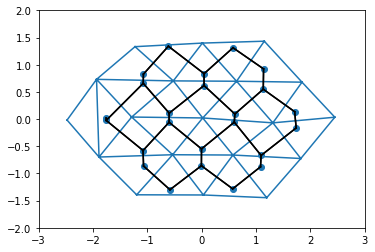

In [ ]:
temp_plot(meshes[-1])
dual = np.stack([fc.dual_coords for fc in meshes[-1].faces.values()])
plt.scatter(*dual.T)

In [ ]:
get_E, grd = meshes[-1].get_primal_energy_fct()
x0 = meshes[-1].dual_vertices_to_initial_cond()
sol = optimize.minimize(get_E, x0, jac=grd, method="BFGS", tol=1e-3)
sol

      fun: 3.2128879658468564e-06
 hess_inv: array([[ 0.65429254,  0.2782018 ,  0.15583314, ...,  0.02342359,
         0.27517297,  0.13834214],
       [ 0.2782018 ,  0.78005968,  0.10114949, ...,  0.13260386,
         0.25142923, -0.02567065],
       [ 0.15583314,  0.10114949,  0.49247652, ...,  0.03316017,
         0.08389883, -0.03517926],
       ...,
       [ 0.02342359,  0.13260386,  0.03316017, ...,  1.08275681,
         0.51617247, -0.50088715],
       [ 0.27517297,  0.25142923,  0.08389883, ...,  0.51617247,
         0.78008127, -0.16681009],
       [ 0.13834214, -0.02567065, -0.03517926, ..., -0.50088715,
        -0.16681009,  1.07476805]])
      jac: array([ 1.20180492e-05, -8.76171463e-05, -4.48906095e-05,  1.92340567e-05,
        4.64871739e-05,  7.08670867e-04, -2.99063267e-06, -4.01520964e-05,
        2.72790008e-05,  8.15967571e-05, -7.08129924e-04,  1.48532556e-05,
       -3.78713961e-05,  8.19362682e-05, -4.82461391e-04,  3.69571365e-05,
        2.04931432e-05, -7.2329

In [ ]:
# maybe package this iteration a little bit ...

## Old code

In [ ]:
#| notest

# define hessianp using partial differentiation. Direct evaluation too expensive

def hessp(x, p):
    def jac_dot(x): return anp.dot(jac(x), p)
    return agrad(jac_dot)(x)
%time _ = hessp(x0, x0)

CPU times: user 50.1 ms, sys: 289 µs, total: 50.4 ms
Wall time: 47 ms
